<a href="https://colab.research.google.com/github/gravity102424/ESAA/blob/main/ESAA_YB_week07_1_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09 분류 실습 - 캐글 산탄데르 고객 만족 예측

이번에는 캐글의 산탄데르 고객 만족(Santander Customer Satisfaction) 데이터 세트에 대해서 고객 만족 여부를 XGBoost와 LightGBM을 활용해 예측해 보겠다. 산탄데르 고객 만족 예측 분석은 370개의 피처로 주어진 데이터 세트 기반에서 고객 만족 여부를 예측하는 것이다. 산탄데르 은행이 캐글에 경연을 의뢰한 데이터로서 피처 이름은 모두 익명 처리돼 이름만을 가지고 어떤 속성인지는 추정할 수 없다. 클래스 레이블 명은 TARGET이며, 이 값이 1이면 불만을 가진 고객, 0이면 만족한 고객이다.
모델의 성능 평가는 ROC-AUC(ROC 곡선 영역)로 평가합니다. 대부분이 만족이고 불만족인 데이터는 일부일 것이기 때문에 정확도 수치보다는 ROC—AUC가 더 적합하다.

# 데이터 전처리
XGBoost는 사이킷런 래퍼를 이용할 것이다. 필요한 모듈을 로딩하고 학습 데이터를 DataFrame 으로 로딩한다.

In [1]:
!pip install xgboost==1.7.6
!pip install lightgbm==4.1.0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings

warnings.filterwarnings('ignore')
cust_df = pd.read_csv("./train_santander.csv", encoding='latin-1')
print('dataset shape：',cust_df.shape)
cust_df.head(3)

dataset shape： (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


클래스 값 칼럼을 포함한 피처가 3기개 존재한다. 피처의 타입과 Null 값을 좀 더 알아보겠다.

In [3]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


Ill개의 피처가 float 형, 260개의 피처가 int 형으로 모든 피처가 숫자 형이며, Null 값은 없다. 전체 데이터에서 만족과 불만족의 비율을 살펴보겠다. 레이블인 Target 속성의 값의 분포를 알아 보면 된다. 대부분이 만족이며 불만족인 고객은 얼마 되지 않는 4%에 불과하다.

In [4]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 베율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 베율은 0.04


DataFrame의 describe() 메서드를 이용해 각 피처의 값 분포를 간단히 확인해 보자.

In [5]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


var3 칼럼의 경우 min 값이 -999999이다. NaN이나 특정 예외 값을 -99999로 변환했을 것이다. print(cust_df.var3.value_counts( )[:10])로 var3의 값을 조사해 보면 -999999 값이 116개가 있음을 알 수 있다. var3은 숫자 형이고, 다른 값에 비해 -999999은 너무 편차가 심하므로 -999999를 가장 값이 많은 2로 변환하겠다. ID 피처는 단순 식별자에 불과하므로 피처를 드롭하겠다. 그리고 클래스 데이터 세트와 피처 데이터 세트를 분리해 별도의 데이터 세트로 별도로 저장하겠다.

In [6]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)
 # 피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1 로 분리
X_features = cust_df.iloc[:, :-1 ]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape：{0}'.format(X_features.shape))

피처 데이터 shape：(76020, 369)


학습과 성능 평가를 위해서 원본 데이터 세트에서 학습 데이터 세트와 테스트 데이터 세트를 분리하겠다. 비대칭한 데이터 세트이므로 클래스인 Target 값 분포도가 학습 데이터와 테스트 데이터 세트에 모두 비슷하게 추출됐는지 확인하겠다.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test. count()
print('학습 세트 Shape：{0}, 테스트 세트 Shape：{1}' .format(X_train.shape, X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape：(60816, 369), 테스트 세트 Shape：(15204, 369)
 학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


학습과 테스트 데이터 세트 모두 TARGET의 값의 분포가 원본 데이터와 유사하게 전체 데이터의 4% 정도의 불만족 값(값 1)으로 만들어졌다.

XGBoost의 조기 중단(early stopping)의 검증 데이터 세트로 사용하기 위해서 X_train, y_train을 다시 쪼개서 학습과 검증 데이터 세트로 만들겠다.

In [8]:
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

# XGBoost 모델 학습과 하이퍼 파라미터 튜닝
먼저 XGBoost의 학습 모델을 생성하고 예측 결과를 ROC AUC로 평가해 보겠다. 사이킷런 래퍼인 XGBClassifier를 기반으로 학습을 수행합니다. n_estimators는 500으로 하되 early_stopping_rounds를 100으로 설정한다. 성능 평가 기준이 ROC—AUC이므로 XGBClassifier의 eval_metric
은 'auc'로 하겠다(logloss로 해도 큰 차이는 없다). 앞에서 분리한 학습과 검증 데이터 세트를 이용하여 eval_set=[(X_tr, y_tr), (X_val, y_val)]로, 조기 중단은 100회로 설정하고 학습을 진행한 뒤 테스트 데이터 세트로 평가된 ROC-AUC 값을 확인해 보겠다.

In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정.
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric="auc", eval_set=[(X_tr, y_tr),
                                                                                (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82179	validation_1-auc:0.80068
[1]	validation_0-auc:0.82347	validation_1-auc:0.80523
[2]	validation_0-auc:0.83178	validation_1-auc:0.81097
[3]	validation_0-auc:0.83401	validation_1-auc:0.81091
[4]	validation_0-auc:0.83443	validation_1-auc:0.81040
[5]	validation_0-auc:0.83570	validation_1-auc:0.81089
[6]	validation_0-auc:0.83597	validation_1-auc:0.81057
[7]	validation_0-auc:0.83643	validation_1-auc:0.81082
[8]	validation_0-auc:0.83682	validation_1-auc:0.81147
[9]	validation_0-auc:0.83769	validation_1-auc:0.81188
[10]	validation_0-auc:0.83770	validation_1-auc:0.81163
[11]	validation_0-auc:0.83911	validation_1-auc:0.81355
[12]	validation_0-auc:0.83976	validation_1-auc:0.81336
[13]	validation_0-auc:0.84038	validation_1-auc:0.81365
[14]	validation_0-auc:0.84176	validation_1-auc:0.81419
[15]	validation_0-auc:0.84306	validation_1-auc:0.81586
[16]	validation_0-auc:0.84343	validation_1-auc:0.81610
[17]	validation_0-auc:0.84373	validation_1-auc:0.81584
[18]	validation_0-au

테스트 데이터 세트로 예측 시 ROC AUC는 약 0.8429이다.

이제 HyperOpt를 이용해 베이지안 최적화 기반으로 XGBoost의 하이퍼 파라미터 튜닝을 수행해 보겠다. 먼저 max_depth는 5에서 15까지 1 간격으로, min_child_weight는 1에서 6까지 1 간격으로, colsample_bytree는 0.5에서 0.95 사이, learning_rate는 0.01 에서 0.2 사이 정규 분포된 값
으로 하이퍼 파라미터 검색 공간을 설정하겠다.

In [10]:
from hyperopt import hp
# max_depth는 5에서 15까지 1 간격으로, min_child_weight는 1에서 6까지 1 간격으로
# colsample_bytree는 0.5에서 0.95 사이, learning_rate는 0.01 에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample.bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2) }

다음으로 목적 함수를 만들어 보겠습니다. 목적 함수는 3 Fold 교차 검증을 이용해 평균 ROC- AUC 값을 반환하되 -1을 곱해주어 최대 ROC-AUC 값이 최소 반환값이 되게 합니다. 교차 검증 시 XGBoost의 조기 중단과 검증 데이터 성능 평가를 위해서 KFold 클래스를 이용하여 직접 학습과 검증
데이터 세트를 추출하고 이를 교차 검증 횟수만큼 학습과 성능 평가를 수행한다. 수행 시간을 줄이기 위해 estimators는 100으로 줄이고, early_stopping_rounds도 30으로 줄여서 테스트한 뒤 나중에 하이퍼 파라미터 튜닝이 완료되면 다시 증가시키겠다.

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# fmin()에서 호출 시 search_space 값으로 XGBClassifier 교차 검증 학습 후 -1* roc_auc 평균 값을 반환.
def objective_func(search_space):
  xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                          min_child_weight=int(search_space['min_child_weight']),
                          colsample_bytree=search_space['colsample_bytree'],
                          learning_rate=search_space['learning_rate'])

  # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list = [ ]
  # 3개 k-fold 방식 적용
  kf = KFold(n_splits=3)
  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index, val_index in kf.split(X_train):
    # kf .split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

    # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
    xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric="auc",
              eval_set=[(X_tr, y_tr), (X_val, y_val)])
    # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음.
    score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1 ])
    roc_auc_list.append(score)

  # 3개 k-fold로 계산된 roc.auc 값의 평균값을 반환하되,
  # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
  return -1*np.mean(roc_auc_list)

이제 fmin() 함수를 호출해 max_eval=50회만큼 반복하면서 최적의 하이퍼 파라미터를 도출해 보겠다. 아래 예제는 50회만큼 교차 검증을 반복하여 학습과 평가를 하므로 저자의 노트북에서 약 30분이 된다.

In [14]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin() 함수를 호출. max.evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정한다.
            trials=trials, rstate=np.random.default_rng(seed=30))
print('best:', best)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[16]	validation_0-auc:0.88976	validation_1-auc:0.82085
[17]	validation_0-auc:0.89035	validation_1-auc:0.81992
[18]	validation_0-auc:0.89422	validation_1-auc:0.82499
[19]	validation_0-auc:0.89845	validation_1-auc:0.82624
[20]	validation_0-auc:0.90086	validation_1-auc:0.82793
[21]	validation_0-auc:0.90190	validation_1-auc:0.82629
[22]	validation_0-auc:0.90439	validation_1-auc:0.82729
[23]	validation_0-auc:0.90507	validation_1-auc:0.82820
[24]	validation_0-auc:0.90590	validation_1-auc:0.82771
[25]	validation_0-auc:0.90669	validation_1-auc:0.82847
[26]	validation_0-auc:0.90836	validation_1-auc:0.82965
[27]	validation_0-auc:0.90970	validation_1-auc:0.82947
[28]	validation_0-auc:0.91131	validation_1-auc:0.83014
[29]	validation_0-auc:0.91183	validation_1-auc:0.83063
[30]	validation_0-auc:0.91203	validation_1-auc:0.83035
[31]	validation_0-auc:0.91254	validation_1-auc:0.83014
[32]	validation_0-auc:0.91333	validation_1-auc:0.82944
[33]	validation_0-auc:0.91352

colsamplbej3ytree가' 약' 0.5749, learning_rate가‘ 익' 0.1514, max_depth는 5.0, min_child_weight는 6.0이 도출됐다.

이제 이렇게 도출된 최적 하이퍼 파라미터를 기반으로 XGBClassifier를 재학습시키고 테스트 데이터 세트에서 ROC AUC를 측정해 보겠다. n_estimators는 500으로 증가시키겠다.

In [22]:
# n_estimators를 500 증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=round(best['learning_rate'], 5),
                        max_depth=int(best['max_depth']),
                        min_child_weight=int(best['min_child_weight']),
                        colsample_bytree=round(best['colsample_bytree'], 5)
)
# evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행.
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {:.4f}'.format(xgb_roc_score))

KeyError: 'colsample_bytree'

ROC—AUC가 이전 예제의 0.8429에서 하이퍼 파라미터 튜닝 이후 0.8457로 개선됐다. 물론 시간을 투자한 것만큼은 아닐 수 있으나 캐글과 같이 치열한 순위 경쟁이 필요한 경우에는 이 정도의 수치 개선은 도움이 될 수 있다.

한 가지 아쉬운 점은 XGBoost가 GBM보다는 빠르지만 아무래도 GBM을 기반으로 하고 있기 때문에 수행 시간이 상당히 더 많이 요구된다는 점이다. 앙상블 계열 알고리즘에서 하이퍼 파라미터 튜닝으로 성능 수치 개선이 급격하게 되는 경우는 많지 않다. 앙상블 계열 알고리즘은 과적합이나 잡음에 기본적으로 뛰어난 알고리즘이기에 그렇다.

튜닝된 모델에서 각 피처의 중요도를 피처 중요도 그래프로 나타내 보겠다. xgboost 모듈의 plot_importance() 메서드를 이용한다.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

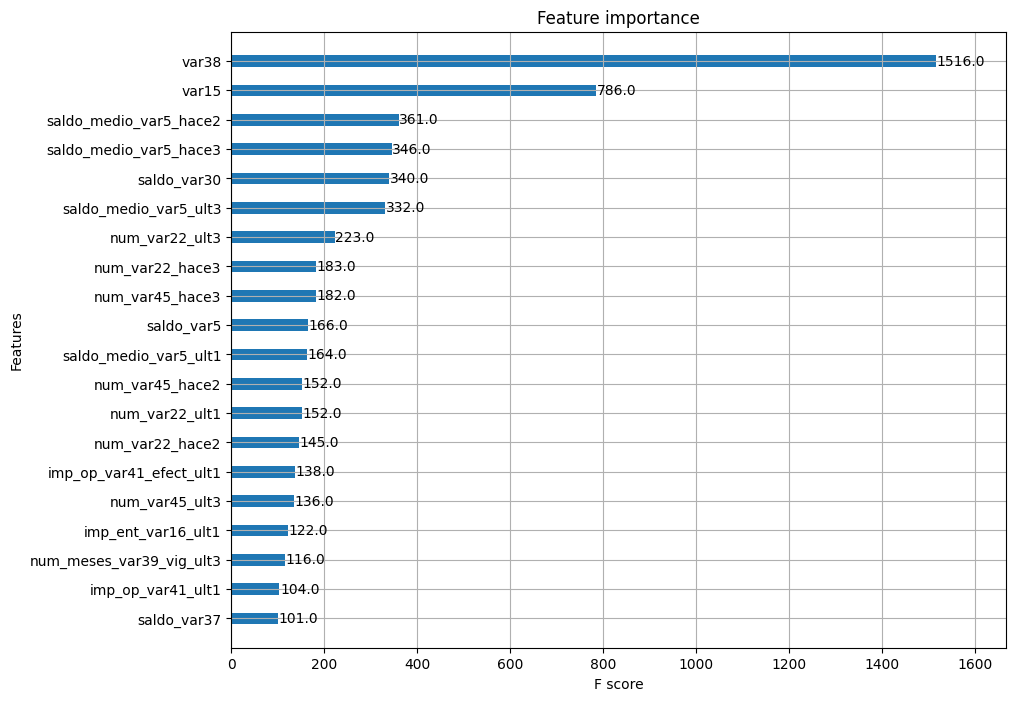

In [16]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1, figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

XGBoost의 예측 성능을 좌우하는 가장 중요한 피처는 var38, varl5 순이다. 다음은 LightGBM을 이용해 모델을 학습하고 하이퍼 파라미터를 튜닝해 예측 성능을 평가해 보겠다.

# LightGBM 모델 학습과 하이퍼 파라미터 튜닝
앞의 XGBoost 예제 코드에서 만들어진 데이터 세트를 기반으로 LightGBM으로 학습을 수행하고, ROC-AUC를 측정해 보겠다. 앞의 XGBoost 예제와 동일하게 n_estimators는 500으로 설정하고, early_stopping_rounds는 100, 앞에서 분리한 학습과 검증 데이터 세트를 이용하여 eval_set=[(X_tr, y_tr),(X_val, y_val)]으로 학습을 진행한 뒤 테스트 데이터 세트로 평가된 ROC-AUC 값을 확인해 보자.

In [23]:
from lightgbm import LGBMClassifier, early_stopping

lgbm_clf = LGBMClassifier(n_estimators=500)

eval_set = [(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, callbacks=[early_stopping(stopping_rounds=100)], eval_metric="auc", eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13308
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 242
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	training's auc: 0.91059	training's binary_logloss: 0.112183	valid_1's auc: 0.831787	valid_1's binary_logloss: 0.13527
ROC AUC: 0.8384


LightGBM 수행 결과 ROC AUC가 약 0.8384를 나타낸다. LightGBM을 직접 수행해 보면 XGBoost보다 학습에 걸리는 시간이 좀 더 단축됐음을 느낄 수 있을 것이다. HyperOpt를 이용하여
다양한 하이퍼 파라미터에 대한 튜닝을 수행해 보겠습니다. 튜닝 대상은 numjeaves, max_depth,
min_child_samples, subsample, learning_rate이며 이를 위한 하이퍼 파라미터 검색 공간을 설정
합니다

In [24]:
lgbm_search_space = {'num_leaves':hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth':hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples':hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample':hp.uniform('subsample', 0.7, 1),
                     'learning_rate':hp.uniform('learning_rate', 0.01, 0.2)}

이제 목적 함수를 생성해 보겠다. 소스 코드는 앞 XGBoost와 크게 다르지 않으며, 단지 LGBMClassifier 객체를 생성하는 부분만 달라진다.

In [25]:
def objective_func(search_space):
  lgbm_clf = LGBMClassifier(n_estimators=100,
                            num_leaves=int(search_space['num_leaves']),
                            max_depth=int(search_space['max_depth']),
                            min_child_samples=int(search_space['min_child_samples']),
                            subsample=search_space['learning_rate'],
                            learning_rate=search_space['learning_rate'])
  # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list=[]

  # 3개 k-fold 방식 적용
  kf = KFold(n_splits=3)
  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index, val_index in kf.split(X_train):
    # kf,split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
    X_tr, y_tr=X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val=X_train.iloc[val_index], y_train.iloc[val_index]

    # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
    lgbm_clf.fit(X_tr, y_tr, callbacks=[early_stopping(stopping_rounds=30)], eval_metric="auc",
                 eval_set=[(X_tr, y_tr), (X_val,y_val)])

    # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음.
    score=roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:,1])
    roc_auc_list.append(score)

  # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
  # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
  return -1*np.mean(roc_auc_list)

fmin()을 호출하여 최적 하이퍼 파라미터를 도출해 보겠다.

In [26]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin() 함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출.
best=fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,
          max_evals=50, # 최대 반복 횟수를 지정합니다.
          trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

[LightGBM] [Info] Number of positive: 1579, number of negative: 38965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12827
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038945 -> initscore=-3.205872
[LightGBM] [Info] Start training from score -3.205872
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[98]	training's auc: 0.88765	training's binary_logloss: 0.121808	valid_1's auc: 0.831519	valid_1's binary_logloss: 0.135868
[LightGBM] [Info] Number of positive: 1609, number of negative: 38935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046324 seconds.
You can set `force_row_wise=true` 

learning_rate가 약 0.08592, max_depth가 121.0, min_child_samples가 69.0, num_leaves가 41.0, subsample이 0.91489로 도출되었다. 이제 이들 하이퍼 파라미터를 이용하여 LightGBM을 학습 후에 테스트 데이터 세트에서 ROC-AUC를 평가해 보겠다.

In [27]:
lgbm_clf = LGBMClassifier(n_estimators=500, num_leaves=int(best['num_leaves']),
                          max_depth=int(best['max_depth']),
                          min_child_samples=int(best['min_child_samples']),
                          subsample=round(best['subsample'],5),
                          learning_rate=round(best['learning_rate'],5))

# evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행.
lgbm_clf.fit(X_tr, y_tr, callbacks=[early_stopping(stopping_rounds=100)],
             eval_metric="auc", eval_set=[(X_tr, y_tr), (X_val, y_val)])

lgbm_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13001
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 202
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	training's auc: 0.899119	training's binary_logloss: 0.11717	valid_1's auc: 0.833934	valid_1's binary_logloss: 0.13474
ROC AUC: 0.8429


LightGBM의 경우 테스트 데이터 세트에서 ROC-AUC가 약 0.8446으로 측정됐다. LightGBM의 경우 학습 시간이 상대적으로 빠르기 때문에 위에 기술된 하이퍼 파라미터 외에 추가적인 하이퍼 파라미터를 적용해서 튜닝을 수행해 보는 것도 좋다.


# 10. 분류 실습 - 캐글 신용카드 사기 검출
이번에는 Kaggle의 신용카드 데이터 세트를 이용해 신용카드 사기 검출 분류 실습을 수행해 보겠다.

해당 데이터 세트의 레이블인 Class 속성은 매우 불균형한 분포를 가지고 있다. Class는 0과 1로 분류되는데 0이 사이가 아닌 정상적인 신용카드 트랜잭션 데이터, 1은 신용카드 사기 트랜잭션을 의미한다. 전체 데이터의 약 0.172%만이 레이블 값이 1, 즉 사기 트랜잭션이다. 일반적으로 사기 검출(Fraud Detection)이나 이상 검출(Anomaly Detection)과 같은 데이터 세트는 이처럼 레이블 값이 극도로 불균형한 분포를 가지기 쉽다. 왜냐하면 사기와 같은 이상 현상은 전체 데이터에서 차지하는 비중이 매우 적을 수밖에 없기 때문이다.

# 언더 샘플링과 오버 샘플링의 이해

레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때 예측 성능의 문제가 발생할 수 있는데, 이는 이상 레이블을 가지는 데이터 건수는 매우 적기 때문에 제대로 다양한 유형을 학습하지 못하는 반면에 정상 레이블을 가진 데이터 건수에 비해 너무 적기 때문에 발생한다. 즉 이상 레이블을 가지는 데이터 건수는 매우 적기 때문에 제대호 다양한 유형을 학습하지 못하는 반면에 정상 레이블을 가지는 데이터 건수는 매우 많기 때문에 일방적으로 정상 레이블로 치우친 학습을 수행해 제대로 된 이상 데이터 검출이 어려워지기 쉽다. 지도학습에서 극도로 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해서는 적절한 학습 데이터를 확보하는 방안이 필요한데, 대표적으로 오버 샘플링(Oversampling)과 언더 샘플링(Undersampling) 방법이 있으며, 오버 샘플링 방식이 예측 성능상 조금 유리한 경우가 많아 상대적으로 더 많이 사용된다.

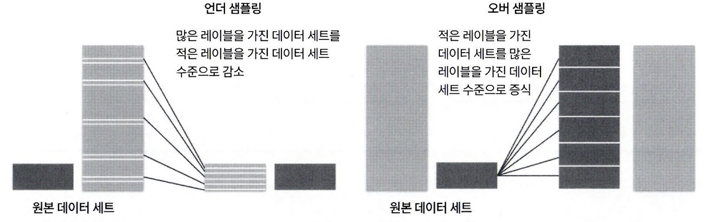

* 언더 샘플링은 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식이다. 즉 정상 레이블을 가진 데이터가 10,000건, 이상 레이블을 가진 데이터가 100건이 있으면 정상 레이블 데이터를 100건으로 줄여 버리는 방식이다. 이렇게 정상 레이블 데이터를 이상 레이블 데이터 수준으로 줄여 버린 상태에서 학습을 수행하면 과도하게 정상 레이블로 학습/예측하는 부작용을 개선할 수 있지만, 너무 많은 정상 레이블 데이터를 감소시켜서 정상 레이블의 경우 제대로 된 학습을 수행할 수 없는 문제가 발생할 수도 있으므로 유의해야 한다.
* 오버 샘플링은 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법이다. 동일한 데이터를 단순히 증식하는 방법은 과적합(Overfitting)이 되기 때문에 의미가 없으므로 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식한다. 대표적으로 SMOTE(Synthetic Minority Over-sampling Technique) 방법이 있다. SMOTE는 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃(K Nearest Neighbor)을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식이다.

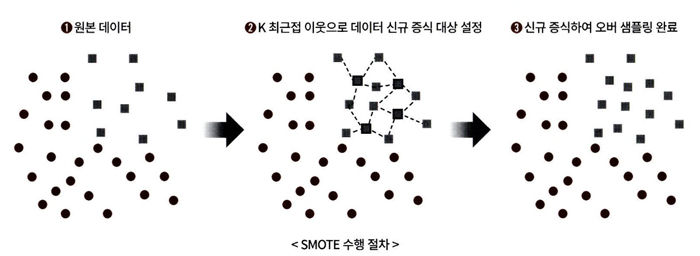

SMOTE를 구현한 대표적인 파이썬 패키지는 imbalanced-learn이다. 이번 절에서는 이를 이용해 데이터를 증식해 보겠다. imbalanced-learn 패키지는 아나콘다를 이용해 설치가 가능하다. 아나콘다 프롬프트를 관리자 권한으로 실행하고 다음 명령어를 입력하면 자동으로 설치를 진행한다.

In [28]:
%pip install imbalanced-learn

# 데이터 일차 가공 및 모델 학습/예측/평가
설치가 됐으면 이제 데이터 세트를 로딩하고 신용카드 사기 검출 모델을 생성하겠다. 새로운 주피터 노트북을 생성하고, 다운로드 받은 creditcard.csv 파일을 동일한 디렉터리로 이동시킨 후 DataFrame으로 로딩한다.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('/content/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


creditcard.csvv의 V로 시작하는 피처들의 의미는 알 수가 없다. Time 피처의 경우는 데이터 생성 관련한 작업용 속성으로서 큰 의미가 없기에 제거하겠다. Amount 피처는 신용카드 트랜잭션 금액을 의미하며, Class는 레이블로서 0의 경우 정상, 1의 경우 트랜잭션이다. card_df.info()로 확인해 보면 전체 284,807개의 레코드에서 결측지(Missing Value)는 없으며, Class 레이블만 int형이고 나머지 피처들은 모두 float형이다.

이번 실습에서는 보다 다양한 데이터 사전 가공을 수행하고, 이에 따른 예측 성능도 함께 비교해 보겠다. 이를 위해 인자로 입력된 DataFrame을 복사한 뒤, 이를 가공하여 반환하는 get_preprocessed_df() 함수와 데이터 가공 후 학습/테스트 데이터 세트를 반환하는 get_train_test_df() 함수를 생성하겠다. 먼저 get_preprocessed_df() 함수는 불필요한 Time 피처만 삭제하는 것으로부터 시작하겠다.

In [30]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time', axis=1, inplace=True)
  return df_copy

get_train_test_dataset()는 get_preprocessed_df()를 호출한 뒤 학습 피처/레이블 데이터 세트, 테스트 피처/레이블 데이터 세트를 반환한다. get_train_test_dataset()는 내부에서 train_test_split() 함수를 호출하며, 테스트 데이터 세트를 전체의 30%인 Stratified 방식으로 추출해 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 분포도를 서로 동일하게 만든다.

In [31]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
  # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy = get_preprocessed_df(df)
  # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features = df_copy.iloc[:, :-1]
  y_target = df_copy.iloc[:, -1]
  # train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 불할
  X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
  # 학습과 테스트 데이터 세트 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

생성한 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 비율을 백분율로 환산해서 서로 비슷하게 분할됐는지 확인해 보겠다.

In [32]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


학습 데이터 레이블의 경우 1값이 약 0.172%, 테스트 데이터 레이블의 경우 1값이 약 0.173%로 큰 차이가 없이 잘 분할됐다. 이제 모델을 만들어 보겠다. 로지스틱 회귀와 LightGBM 기반의 모델이 데이터 가공을 수행하면서 예측 성능이 어떻게 변하는지 살펴볼 것이다. 먼저 로지스틱 회귀를 이용해 신용 카드 사기 여부를 예측해 보겠다. 예측 성능 평가는 3장에서 생성한 get_clf_eval() 함수를 다시 사용하겠다.

In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test , pred)
  precision = precision_score(y_test , pred)
  recall = recall_score(y_test , pred)
  f1 = f1_score(y_test,pred)
  # ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1： {3:.4f}, AUC：{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


In [34]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

# 3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행.
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8667, 재현율: 0.6149, F1： 0.7194, AUC：0.9741



테스트 데이터 세트로 측정 시 재현율(Recall)이 0.6216, ROC—AUC가 0.9702이다. 이번에는 LightGBM을 이용한 모델을 만들어 보겠다. 그에 앞서, 앞으로 수행할 예제 코드에서 반복적으로 모델을 변경해 학습/예측/평가할 것이므로 이를 위한 별도의 함수를 생성하겠다. get_model_train_eval()는 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력받아서 학습/예측/평가를 수행하는 역할을 하는 함수이다.

In [35]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test, pred, pred_proba)

먼저, 본 데이터 세트는 극도로 불균형한 레이블 값 분포도를 가지고 있으므로 LGBMClassifier 객체 생성 시 boost_from_average=False로 파라미터를 설정해야 한다.

LightGBM으로 모델을 학습한 뒤, 별도의 테스트 데이터 세트에서 예측 평가를 수행해 보겠다.

In [36]:
from lightgbm import LGBMClassifier

lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

재현율 0.7568, ROC-AUC 0.9790으로 앞의 로지스틱 회귀보다는 높은 수치를 나타냈다.

# 데이터 분포도 변환 후 모델 학습/예측/평가
이번에는 왜곡된 분포도를 가지는 데이터를 재가공한 뒤에 모델을 다시 테스트해 보겠다. 먼저 creditcard.csv의 중요 피처 값의 분포도를 살펴본다. 5장에서 더 자세히 설명하겠지만, 로지스틱 회귀는 선형 모델이다. 대부분의 선형 모델은 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호한다. Amount 피처는 신용 카드 사용 금액으로 정상/사기 트랜잭션을 결정하는 매우 중요한 속성일 가능성이 높다. Amount 피처의 분포도를 확인해 보겠다.

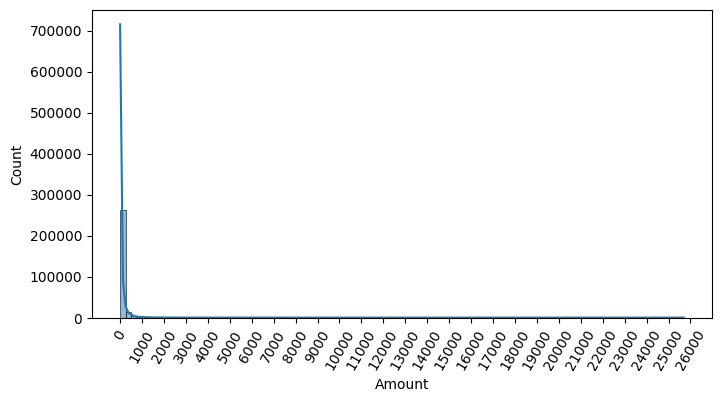

In [37]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000),rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

Amount, 즉 카드 사용금액이 1000불 이하인 데이터가 대부분이며, 26,000불까지 드물지만 많은 금액을 사용한 경우가 발생하면서 꼬리가 긴 형태의 분포 곡선을 가지고 있다. Amount를 표준 정규 분포 형태로 변환한 뒤에 로지스틱 회귀의 예측 성능을 측정해 보겠다. 이를 위해 앞에서 만든 get_processed_df() 함수를 다음과 같이 사이킷런의 StandardScaler 클래스를 이용해 Amount 피처를 정규 분포 형태로 변환하는 코드로 변경한다.

In [38]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame 맨 앞 칼럼으로 입력
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time','Amount'], axis=1, inplace=True)
  return df_copy

함수를 수정한 후 get_train_test_dataset()를 호출해 학습/테스트 데이터 세트를 생성한 후에 get_model_train_eval()를 이용해 로지스틱 회귀와 LightGBM 모델을 각각 학습/예측/평가해 보겠다.

In [39]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행.
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LoghtGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   55    93]]
정확도: 0.9992, 정밀도: 0.8692, 재현율: 0.6284, F1： 0.7294, AUC：0.9706
### LoghtGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

정규 분포 형태로 Amount 피처값을 변환한 후 테스트 데이터 세트에 적용한 로지스틱 회귀의 경우는 정밀도와 재현율이 오히려 조금 저하되었고, LightGBM의 경우는 약간 정밀도와 재현율이 저하되었지만 큰 성능상의 변경은 없다.

이번에는 StandardScaler가 아니라 로그 변환을 수행해 보겠다. 로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중에 하나이다. 원래 값을 log 값으로 변환해 원래 큰 값을 상대적으로 작은 값으로 변환하기 때문에 데이터 분포도의 왜곡을 상당 수준 개선해 준다. 로그 변환은 넘파이의 log1p() 함수를 이용해 간단히 변환이 가능하다. 데이터 가공 함수인 get_preprocessed_df()를 다음과 같이 로그 변환 로직으로 변경한다.

In [40]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  # 넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount_Scaled', amount_n)
  df_copy.drop(['Time','Amount'], axis=1, inplace=True)
  return df_copy

이제 Amount 피처를 로그 변환후 다시 로지스틱 회귀와 LightGBM 모델을 적용한 후 예측 성능을 확인해 보겠다.

In [41]:
X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train,
                     tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train,
                     tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85282    13]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8725, 재현율: 0.6014, F1： 0.7120, AUC：0.9734
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

로지스틱 회귀의 경우 원본 데이터 대비 정밀도는 향상되었지만 재현율은 저하되었다. LightGBM의 경우 재현율이 향상되었다. 레이블이 극도로 불균일한 데이터 세트에서 로지스틱 회귀는 데이터 변환 시 약간은 불안정한 성능 결과를 보여 주고 있다.

# 이상치 데이터 제거 후 모델 학습/예측/평가
이상치 데이터(Outlier)는 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터이며, 아웃라이어라고도 불린다. 이상치로 인해 머신러닝 모델의 성능에 영향을 받는 경우가 발생하기 쉽다. 이번에는 이러한 이상치를 찾아내는 방법을 소개하고, 이들 데이터를 제거한 뒤에 다시 모델을 평가해 보겠다. 이상치를 찾는 방법은 여러 가지가 있지만, 이 중에서 IQR(Inter Quantile Range) 방식을 적용해 보겠다. IQR은 사분위(Quantile) 값의 편차를 이용하는 기법으로 흔히 박스 플롯(Box Plot)방식으로 시각화할 수 있다.

먼저 사분위에 대해 알아보자. 사분위는 전체 데이터를 값이 높은 순으로 정렬하고, 이를 1/4(25%)씩으로 구간을 분할하는 것을 지칭한다. 가령 100명의 시험 성적이 0점부터 100점까지 있다면, 이를 100등부터 1등까지 성적순으로 정렬한 뒤에 1/4 수산으로 Q1, Q2, Q3, Q4와 같이 나누는 것이다. 이들 중 25% 구간인 Q1~75% 구간인 Q3의 범위를 IQR이라고 한다. 다음 그림은 사분위와 IQR을 표현한 것이다.

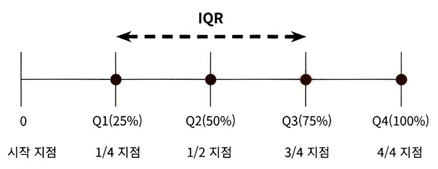

IQR을 이용해 이상치 데이터를 검출하는 방식은 보통 IQR에 1.5를 곱해서 생성된 범위를 이용해 최댓값과 최솟값을 결정한 뒤 최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치로 간주하는 것이다. 3/4 분위수(Q3)에 IQR1.5를 더해서 일반적인 데이터가 가질 수 있는 최댓값으로 가정하고, 1/4 분위수(Q1)에 IQR1.5를 빼서 일반적인 데이터가 가질 수 있는 최솟값으로 가정한다. 경우에 따라서 1.5가 아닌 다른 값을 적용할 수도 있으며, 보통은 1.5를 적용한다. 이렇게 결정된 최댓값보다 큰 값 또는 최솟값보다 작은 값을 이상치 데이터로 간주한다. IQR 방식을 시각화한 도표가 박스 플롯이다. 박스 플롯은 다음과 같은 표현 방식으로 사분위의 편차와 IQR, 그리고 이상치를 나타낸다.

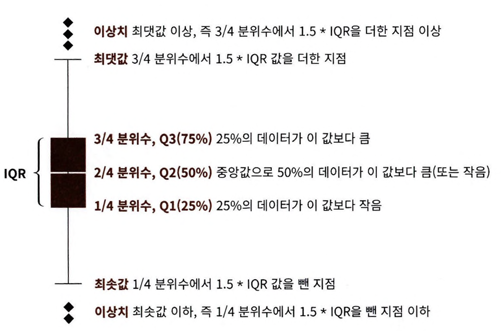

이제 이상치 데이터를 IQR을 이용해 제거해 보겠다. 먼저 어떤 피처의 이상치 데이터를 검출할 것인지 선택이 필요하다. 매우 많은 피처가 있을 경우 이들 중 결정값(즉 레이블)과 가장 상관성이 높은 피처들을 위주로 이상치를 검출하는 것이 좋다. 모든 피처들의 이상치를 검출하는 것은 시간이 많이 소모되며, 결정값과 상관성이 높지 않은 피처들의 경우는 이상치를 제거하더라도 크게 성능 향상에 기여하지 않기 때문이다. DataFrama의 corr()을 이용해 각 피처별로 상관도를 구한 뒤 시본의 heatmap을 통해 시각화해 보겠다.

<Axes: >

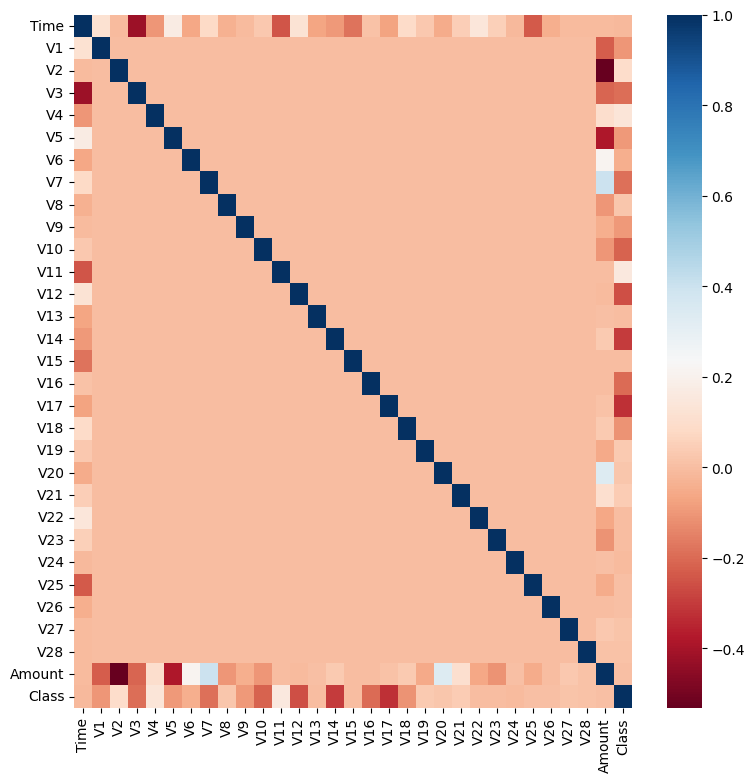

In [42]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

상관관계 히트맵에서 cmap을 'RdBu'로 설정해 양의 상관관계가 높을수록 색깔이 진한 파란색에 가까우며, 음의 상관관계가 높을수록 색깔이 진한 빨간색에 가깝게 표현된다. 상관관계 히트맵에서 맨 아래에 위치한 결정 레이블인 Class 피처와 음의 상관관계가 가장 높은 피처는 V14와 V17이다. 이 중 V14에 대해서만 이상치를 찾아서 제거해 보겠다. IQR을 이용해 이상치를 검출하는 함수를 생성한 뒤, 이를 이용해 검출된 이상치를 삭제한다. get_outlier() 함수는 인자로 DataFrame과 이상치를 검출한 칼럼을 입력받는다. 함수 내에서 넘파이의 percentile()을 이용해 1/4 분위와 3/4 분위를 구하고, 이에 기반해 IQR을 계산한다. 계산된 IQR에 1.5를 곱해서 최댓값과 최솟값 지점을 구한 뒤, 최댓값보다 크거나 최솟값보다 작은 값을 이상치로 설정하고 해당 이상치가 있는 DataFrame Index를 반환한다.

In [43]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
  # froud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
  fraud = df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)
  # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr*weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight
  # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환.
  outlier_index = fraud[(fraud < lowest_val)|(fraud > highest_val)].index
  return outlier_index

get_outlier() 함수를 이용해 V14 칼럼에서 이상치 데이터를 찾아보겠다.

In [44]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


총 4개의 데이터인 8296, 8615, 9035, 9252번 Index가 이상치로 추출됐다. get_outllier()을 이용해 이상치를 추출하고 이를 삭제하는 로직을 get_processed_df() 함수에 추가해 데이터를 가공한 뒤 이 데이터 세트를 이용해 로지스틱 회귀와 LightGBM 모델을 다시 적용해 보겠다.

In [45]:
# get_precessed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경.
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time','Amount'], axis=1, inplace=True)
  # 이상치 데이터 삭제하는 로직 추가
  outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train,
                     tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85280    15]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8673, 재현율: 0.6712, F1： 0.7568, AUC：0.9725
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 342, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199362, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

이상치 데이터를 제거한 뒤, 로지스틱 회귀와 LightGBM 모두 예측 성능이 크게 향상되었다. 로지스틱 회귀의 경우 재현율이 60.14%에서 67.12%로 크게 증가했으며, LightGBM의 경우도 76.35%에서 82.88%로 역시 크게 증가했다.

# SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
이번에는 SMOTE 기법으로 오버 샘플링을 적용한 뒤 로지스틱 회귀와 LightGBM 모델의 예측 성능을 평가해 보겠다. 먼저 SMOTE는 앞에서 설치한 imbalanced-learn 패키지의 SMOTE 클래스를 이용해 간단하게 구현이 가능하다. SMOTE를 적용할 때는 반드시 학습 데이터 세트만 오버 샘플링을 해야 한다. 검증 데이터 세트나 테스트 데이터 세트를 오버 샘플링할 경우 결국은 원본 데이터 세트가 아닌 데이터 세트에서 검증 또는 테스트를 수행하기 때문에 올바른 검증/테스트가 될 수 없다.

앞 예제에서 생성한 학습 피처/레이블 데이터를 SMOTE 객체의 fit_resample() 메서드를 이용해 증식한 뒤 데이터를 증식 전과 비교해 보겠다.

In [46]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 Class
0    199020
1    199020
Name: count, dtype: int64


SMOTE 적용 전 학습 데이터 세트는 199,362건이었지만 SMOTE 적용 후 2배에 가까운 398,040건으로 데이터가 증식했다. 그리고 SMOTE 적용 후 레이블 값이 0과 1의 분포가 동일하게 199,020 건으로 생성됐다. 이제 이렇게 생성된 학습 데이터 세트를 기반으로 먼저 로지스틱 회귀 모델을 학습한 뒤 성능을 평가해 보겠다.

In [47]:
lr_clf =LogisticRegression(max_iter=1000)
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over,
                     tgt_test=y_test)

오차 행렬
[[82933  2362]
 [   11   135]]
정확도: 0.9722, 정밀도: 0.0541, 재현율: 0.9247, F1： 0.1022, AUC：0.9736


로지스틱 회귀 모델의 경우 SMOTE로 오버 샘플링된 데이터로 학습할 경우 재현율이 92.47%로 크게 증가하지만, 반대로 정밀도가 5.4%로 급격하게 저하된다. 재현율이 높더라도 이 정도로 저조한 정밀도로는 현실 업무에 적용할 수 없다. 이는 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 Class=l 데이터를 학습하면서 실제 테스트 데이터 세트에서 예측을 지나치게 Class=l로 적용해 정밀도가 급격히 떨어지게 된 것이다. 분류 결정 임곗값에 따른 정밀도와 재현율 곡선을 통해 SMOTE로 학습된 로지스틱 회귀 모델에 어떠한 문제가 발생하고 있는지 시각적으로 확인해 보겠다. 이를 위해 3장에서 사용한 precision_recall_curve_plot() 함수를 이용한다.

In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)

    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))

    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

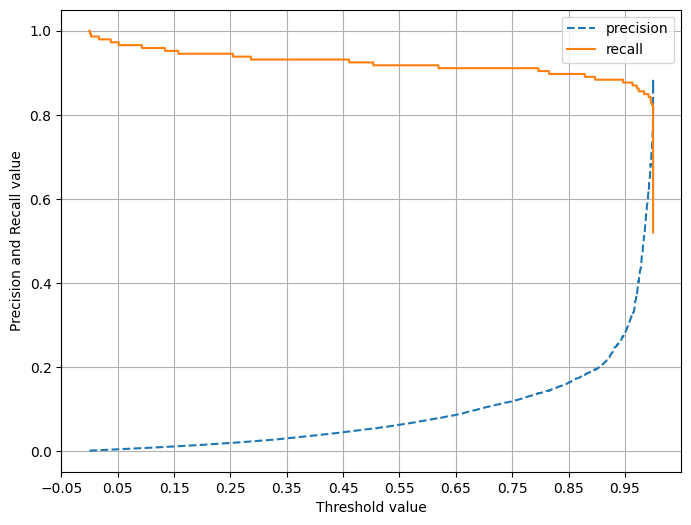

In [49]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

임계값이 0.99 이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮다가 0.99 이상에서는 반대로 재현율이 대폭 떨어지고 정밀도가 높아진다. 분류 결정 임계값을 조정하더라도 임계값의 민감도가 너무 심해 올바른 재현율/정밀도 성능을 얻을 수 없으므로 로지스틱 회귀 모델의 경우 SMOTE 적용 후 올바른 예측 모델이 생성되지 못했다. 이번에는 LightGBM 모델을 SMOTE로 오버 샘플링된 데이터 세트로 학습/예측/평가를 수행하겠다.

In [50]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                     tgt_train=y_train_over, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

재현율이 이상치만 제거한 경우인 82.88%보다 높은 84.93%가 되었다. 그러나 정밀도는 이전의 96.03%보다 낮은 91.18%이다. SMOTE를 적용하면 재현율은 높아지나, 정밀도는 낮아지는 것이 일반적이다. 때문에 정밀도 지표보다는 재현율 지표를 높이는 것이 머신러닝 모델의 주요한 목표인 경우 SMOTE를 적용하면 좋다. 좋은 SMOTE 패키지일수록 재현율 증가율은 높이고 정밀도 감소율은 낮출 수 있도록 효과적으로 데이터를 증식한다.

지금까지 다양한 방법으로 데이터를 가공하면서 로지스틱 회귀와 LightGBM을 적용한 결과를 다음과 같이 정리했다.

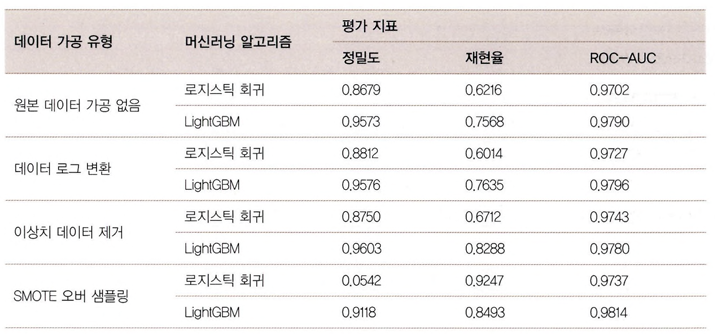